In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

In [1]:
import pandas as pd
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from sklearn.metrics import roc_curve, RocCurveDisplay
from tqdm  import tqdm
import gzip
from Bio import SeqIO
import math
from sklearn.model_selection import train_test_split
# import torch
# from evo2 import Evo2
# from create_embeddings import create_embeddings

In [22]:
prefix = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000")
train_path = Path(f"{prefix}_train_seq.tsv" )
embeddings_path = Path(f"{prefix}_div3_embeddings.tsv.gz")
df = pd.read_csv(train_path, sep="\t", header=0, index_col=0)
em = pd.read_csv(embeddings_path, sep="\t", header=0, index_col=0, compression="gzip")
em.embedding = em.embedding.apply(eval)

In [23]:
df = df.merge(em,
                left_on="segment_id_x",
                right_on="segment_id",
                ).drop(columns=['segment_id']).rename({"embedding":"em_x"}, axis=1)
df = df.merge(em,
                left_on="segment_id_y",
                right_on="segment_id",
                ).drop(columns=['segment_id']).rename({"embedding":"em_y"}, axis=1)

In [24]:
df.head()

,genome_x,chr_x,len_profile_x,segment_id_x,genome_y,chr_y,len_profile_y,segment_id_y,seq_x,seq_y,multiplicon_id,similar,em_x,em_y
0,bol,C3,3,30455,ath,Chr1,7,29092,TTAGGCGCTTTGGCTTGATCCATTTTGTAATCTTTTTTCTTGTTCA...,ATGAACCTTTCCTCTAACGACCAACCAAGCCAAGGCCGTATCAAGG...,NaN,False,"[1.4344397669674436e-08, 7.862217330512067e-07...","[1.6796507296135132e-08, 8.939415465647471e-07..."
1,tha,NW_010960188,6,18945,aar,LG-8,4,18886,ATGGGTATGTGACTTCACAGACCTGAATTACCAAAAAAGTGTGACG...,ATGAAGATGCCAGTAAGTACGTTTCTCCTTTTTTTTAATTATTGTT...,NaN,False,"[2.0119177435162783e-08, 9.96830863186915e-07,...","[2.1260747828932836e-08, 1.0616283816489158e-0..."
2,aar,LG-7,3,29143,ath,Chr2,6,29144,ATGGCTACCGAAGAAGACAAAGCCCTGGAAACTCTTCTTGACGTTC...,TTAATTAACAGCAGAACAAGAACGTCTAATCTCACCTTCTTCACCA...,14572.0,True,"[2.0495686925414702e-08, 1.0472905387359788e-0...","[2.0100509701137526e-08, 1.0208932508248836e-0..."
3,aar,csc-39,4,18617,ath,Chr4,5,26768,ATGCGGGTGCTTGGTTTGAGCTCAAGCTTGTGCTCAAGTGAGGAGA...,ATGATGATGGGTAAAGAGGATTTGGGTTTAAGTCTTAGCTTGGGAT...,NaN,False,"[1.921701375806606e-08, 1.0028629731095862e-06...","[1.7588410727853443e-08, 9.144865771304467e-07..."
4,bol,C2,4,18711,ath,Chr5,5,18712,ATGGGAAGCCAATCATACGAAGACGCCCTCGAAGCTCTCAAGAAGC...,ATGGTCCCCTTTTGGACTACAGTTTCTCGAAATGGCTCATCAGACT...,9356.0,True,"[1.6232325705800577e-08, 8.741048986848909e-07...","[1.6440424133179476e-08, 8.819671393212047e-07..."


In [25]:
seq_x = df.iloc[0].seq_x

In [26]:
evo2_model = Evo2('evo2_1b_base', local_path="/home/jong505/models/evo2_1b_base.pt")
l_name = "blocks.24.mlp.l3"

tok_x = torch.tensor(evo2_model.tokenizer.tokenize(seq_x), dtype=torch.int, ).unsqueeze(0).to('cuda:0')
_, tens_x = evo2_model(tok_x, return_embeddings=True, layer_names=[l_name])
x = tens_x[l_name].cpu().float().numpy()
split = np.array_split(x[0], 3)
out = []
for i in split:
    out += i.mean(axis=0).tolist()

Loading model from /home/jong505/models/evo2_1b_base.pt...
Loading config from /home/jong505/conda/miniconda3/envs/evo2/lib/python3.11/site-packages/evo2/configs/evo2-1b-8k.yml...


100%|██████████| 25/25 [00:00<00:00, 503.09it/s]


Extra keys in state_dict: {'blocks.24.mixer.dense._extra_state', 'unembed.weight', 'blocks.17.mixer.dense._extra_state', 'blocks.3.mixer.dense._extra_state', 'blocks.10.mixer.dense._extra_state'}


/home/jong505/conda/miniconda3/envs/evo2/lib/python3.11/site-packages/transformer_engine/pytorch/module/base.py:630: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = to

In [28]:
print(df.iloc[0].em_x)
print(out)

[1.4344397669674436e-08, 7.862217330512067e-07, 3.405066095751863e-08, 4.298115285905624e-08, 5.6714871021767976e-08, -3.867694786663378e-08, 4.843784484620528e-09, -6.907298200076184e-08, -4.652465435128761e-08, -1.8742888130418578e-08, 2.40084596647705e-09, -6.6272645149467735e-09, -4.581284329674418e-08, -1.2718079034357288e-08, -1.2370950486229049e-08, -4.016566190756521e-09, -3.58325280558347e-08, 2.167432455735252e-08, -8.368946424752721e-08, 3.903891965251205e-08, -1.5299238542709759e-09, -2.3992852149490318e-08, -4.7312628481677166e-08, -1.0384250792583316e-08, 6.718057932175725e-08, 5.452894669133457e-08, -3.0840702436307765e-08, -9.194535799394998e-09, 2.2744274019714794e-08, 3.670248105436258e-08, 2.9011566482495255e-08, 8.378644444917427e-09, 2.7676941627419183e-08, 6.923129625135971e-09, -2.0413450485534668e-08, 7.062153173365004e-08, -4.5741820997591276e-08, -1.4256080760333134e-07, 9.809919099268427e-09, 2.003761778723856e-08, -3.2962649498813335e-08, -2.1079167300541712

# Making sure negative samples don't have the same fam in there

In [125]:
prefix = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000")
results_folder = Path(f"results/{prefix.stem}")

train_path = Path(f"{prefix}_train.tsv" )
train = pd.read_csv(train_path, sep="\t", header=0, index_col=0)

test_path = Path(f"{prefix}_test.tsv" )
test = pd.read_csv(test_path, sep="\t", header=0, index_col=0)

val_seq_path = Path(f"{prefix}_val.tsv" )
val = pd.read_csv(val_seq_path, sep="\t", header=0, index_col=0)

list_elements = Path("/home/jong505/thesis/iadh/iadh_out/aar_ath_bol_chi_cpa_tha/list_elements.txt")
list_elements = pd.read_csv(list_elements, sep='\t', header=0)

merged_path = Path("/home/jong505/thesis/iadh/iadh_out/aar_ath_bol_chi_cpa_tha/merged_results.tsv")
seg_len = 7
merged = pd.read_csv(merged_path, sep="\t", header=0)
merged = merged[(merged["len_profile_x"]<=seg_len) & (merged["len_profile_y"]<=seg_len) & (merged["genome_x"] != merged["genome_y"])]


data_p = Path("/home/jong505/thesis/iadh/data")
refseqs = [f"{data_p}/ath.fasta.gz", f"{data_p}/aar.fasta.gz", f"{data_p}/bol.fasta.gz", f"{data_p}/tha.fasta.gz", f"{data_p}/chi.fasta.gz", f"{data_p}/cpa.fasta.gz"]
refseqs = [Path(f) for f in refseqs]

gene_fam_path = Path("/home/jong505/thesis/iadh/data/gene_fam_parsed.tsv")
gene_fam = pd.read_csv(gene_fam_path, sep="\t", header=None,  names=['gene', 'fam'])

def genes_to_fam(df):
    # create series to map gene to fam
    gene_to_fam = gene_fam.set_index("gene")["fam"]
    df_x = (
        df[["genes_x"]]
        # instead of having i1: [g1, g2 etc] we go to
        # i1: g1
        # i1: g2
        .explode("genes_x")
        # add column fam for wich we map gene_x using gene to fam
        .assign(fam=lambda df: df["genes_x"].map(gene_to_fam))
        # undo the explode
        .groupby(level=0)["fam"]
        # turn every group by section into list
        .agg(list)
        # rename colum fam
        .rename("fams_x")
    )

    df_y = (
        df[["genes_y"]]
        .explode("genes_y")
        .assign(fam=lambda df: df["genes_y"].map(gene_to_fam))
        .groupby(level=0)["fam"]
        .agg(list)
        .rename("fams_y")
    )
    return df.join([df_x, df_y])


In [ ]:
# create series that can be used to map segment to gene
segment_to_gene = list_elements.set_index("segment")["gene"]
# aggregate from:
# seg1: g1
# seg1: g2
# to: seg1: [g1, g2]
segment_to_gene = segment_to_gene.groupby("segment").agg(list)
# add collumn named gene_x in wich we use the segment id to look up what genes are in the segment using segment_to_gene
df = pd.concat([train, test, val])

df = df.assign(genes_x=lambda df: df["segment_id_x"].map(segment_to_gene))
df = df.assign(genes_y=lambda df: df["segment_id_y"].map(segment_to_gene))
df = genes_to_fam(df)
# df["sim"] = [bool(set(x) & set(y)) for x, y in zip(df["fams_x"], df["fams_y"])]

In [134]:
df.columns

Index(['genome_x', 'chr_x', 'len_profile_x', 'segment_id_x', 'genome_y',
       'chr_y', 'len_profile_y', 'segment_id_y', 'multiplicon_id', 'similar',
       'genes_x', 'genes_y', 'fams_x', 'fams_y', 'sim'],
      dtype='object')

In [135]:
bad_negatives = df.query('similar == False').sim.sum()
print(bad_negatives)
print(bad_negatives/df.shape[0])
train.head()

296
0.11186696900982615


,genome_x,chr_x,len_profile_x,segment_id_x,genome_y,chr_y,len_profile_y,segment_id_y,multiplicon_id,similar
820,bol,C3,3,30455,ath,Chr1,7,29092,NaN,False
244,tha,NW_010960188,6,18945,aar,LG-8,4,18886,NaN,False
1223,aar,LG-7,3,29143,ath,Chr2,6,29144,14572.0,True
1636,aar,csc-39,4,18617,ath,Chr4,5,26768,NaN,False
1079,bol,C2,4,18711,ath,Chr5,5,18712,9356.0,True


In [17]:
print("gene fam:")
print(gene_fam.columns)
display(gene_fam.head())
print("List elements:")
print(list_elements.columns)
display(list_elements.head())
print("train:")
print(train.columns)
train.head()

gene fam:
Index(['gene', 'fam'], dtype='object')


,gene,fam
0,AagrBONN_evm.TU.Sc2ySwM_344.5579,HOM05D000001
1,AagrBONN_evm.TU.Sc2ySwM_344.5580,HOM05D000001
2,AagrBONN_evm.TU.Sc2ySwM_344.5581,HOM05D000001
3,AagrBONN_evm.TU.Sc2ySwM_344.5582__5583,HOM05D000001
4,AagrBONN_evm.TU.Sc2ySwM_344.5586,HOM05D000001


List elements:
Index(['id', 'segment', 'gene', 'position', 'orientation'], dtype='object')


,id,segment,gene,position,orientation
0,1,1,BolC5t33707H,0,-
1,2,1,BolC5t33708H,1,-
2,3,1,BolC5t33709H,2,-
3,4,1,BolC5t33710H,3,-
4,5,1,BolC5t33711H,4,+


train:
Index(['genome_x', 'chr_x', 'len_profile_x', 'segment_id_x', 'genome_y',
       'chr_y', 'len_profile_y', 'segment_id_y', 'multiplicon_id', 'similar',
       'genes_x', 'genes_y'],
      dtype='object')


,genome_x,chr_x,len_profile_x,segment_id_x,genome_y,chr_y,len_profile_y,segment_id_y,multiplicon_id,similar,genes_x,genes_y
820,bol,C3,3,30455,ath,Chr1,7,29092,NaN,False,"[BolC3t20284H, BolC3t20285H, BolC3t20286H]","[AT1G68660, AT1G68650, AT1G09003, AT1G68640, A..."
244,tha,NW_010960188,6,18945,aar,LG-8,4,18886,NaN,False,"[THA.LOC104826313, THA.LOC104826329, THA.LOC10...","[Aa31LG8G3910, Aa31LG8G3920, Aa31LG8G3930, Aa3..."
1223,aar,LG-7,3,29143,ath,Chr2,6,29144,14572.0,True,"[Aa31LG7G11570, Aa31LG7G11580, Aa31LG7G11590]","[AT2G24830, AT2G08060, AT2G24820, AT2G24810, A..."
1636,aar,csc-39,4,18617,ath,Chr4,5,26768,NaN,False,"[Aa31csc39G10, Aa31csc39G20, Aa31csc39G30, Aa3...","[AT4G17486, AT4G17470, AT4G17460]"
1079,bol,C2,4,18711,ath,Chr5,5,18712,9356.0,True,"[BolC2t06660H, BolC2t06661H, BolC2t06662H, Bol...","[AT5G14740, AT5G14750, AT5G14760, AT5G14770, A..."


In [ ]:
train["sim_genes"] = train.apply(check_sim_gens, axis=1)
train.query("sim_genes == True")

,genome_x,chr_x,len_profile_x,segment_id_x,genome_y,chr_y,len_profile_y,segment_id_y,multiplicon_id,similar,genes_x,genes_y,sim_genes


In [131]:
test["sim_genes"] = test.apply(check_sim_gens, axis=1)
test.query("sim_genes == True")

,genome_x,chr_x,len_profile_x,segment_id_x,genome_y,chr_y,len_profile_y,segment_id_y,multiplicon_id,similar,genes_x,genes_y,sim_genes


In [138]:
val["sim_genes"] = val.apply(check_sim_gens, axis=1)
print(val.query("sim_genes == True")["genes_x"].to_list())
print(val.query("sim_genes == True")["genes_y"].to_list())

[['Aa31LG10G20', 'Aa31LG10G30', 'Aa31LG10G40', 'Aa31LG10G50', 'Aa31LG10G70']]
[['Aa31LG10G80', 'Aa31LG10G70', 'Aa31LG10G50', 'Aa31LG10G40', 'Aa31LG10G30', 'Aa31LG10G20']]


In [117]:
nested = train.genes_x.tolist()
flat_list = [x for xs in nested for x in xs]
counts = Counter(flat_list)
sum(count>1 for count in counts.values())

1783

# Making sure merged and train have the same stuff based on segement_id_y/x

In [ ]:
def create_train_df(merged: pd.DataFrame, refseq: list):
    #output dict.
    output = {}
    # loop trough reference sequences.
    for file in refseq:
        #open refseq 
        with gzip.open(file, "rt") as f:
            # loop trough files in refseq (wich are mostly chromosones).
            for record in tqdm(SeqIO.parse(f, format="fasta"), desc=f"Collecting sequences from{file}"):
                # get the name of the current name of the refseq (Wich genome we are looking at).
                file_name = file.stem.split(".")[0]
                # get the name of the current file in the refseq (Wich chromosone we are looking at).
                chr_name = record.id.split(".")[0]
                # filter the df such that we are only looking at rows that have a segment that is from the current genome and chromosone.
                # We are doing this to reduce the size of the forloop, to improve speed.
                df_focus = merged[(merged[["genome_x", "genome_y"]] == file_name).any(axis=1) & (merged[["list_x", "list_y"]] == chr_name).any(axis=1)]
                # loop over df
                for indx, r in df_focus.iterrows():
                    # for the current row see if genome_x and or genome_y is the genome that is opened right now.
                    genome = r[r==file_name]
                    # loop over genome_x or genome_y or both debending on what genome is open right now.
                    for i, _ in genome.items():
                        # set x_y to either x or y depending on wich genome we are looking at
                        x_y = i.split("_")[1]
                        # check if the current (iadh) segment is from the correct chromosone that we have opend right now.
                        if r[f"list_{x_y}"] == chr_name:
                            # see if a dict already exists for the current id(indx), if so we update it, if not we create the id and write the inital data.
                            output.setdefault(r["id"], {}).update({f"genome_{x_y}": r[f"genome_{x_y}"],
                                                                f"chr_{x_y}": r[f"list_{x_y}"],
                                                                f"segment_id_{x_y}": r[f"segment_id_{x_y}"],
                                                                f"len_profile_{x_y}": r[f"len_profile_{x_y}"],
                                                                f"seq_{x_y}": str(record.seq[r[f"start_{x_y}"]-1:r[f"stop_{x_y}"]])})
                            
    return pd.DataFrame.from_dict(output, orient='index')[["genome_x", "chr_x", "len_profile_x", "segment_id_x", "genome_y", "chr_y", "len_profile_y", "segment_id_y", "seq_x", "seq_y"]]



In [ ]:
df = create_train_df(merged, refseqs)
df = append_genes(df)

In [88]:
ids = df.sample(n=5).segment_id_y.values
display(df.query('segment_id_y.isin(@ids)')[["segment_id_y", "genes_y"]].sort_values("segment_id_y"))
display(merged.query('segment_id_y.isin(@ids)')[["segment_id_y", "genes_y"]].sort_values("segment_id_y"))

ids = df.sample(n=5).segment_id_x.values
display(df.query('segment_id_x.isin(@ids)')[["segment_id_x", "genes_x"]].sort_values("segment_id_x"))
display(merged.query('segment_id_x.isin(@ids)')[["segment_id_x", "genes_x"]].sort_values("segment_id_x"))

,segment_id_y,genes_y
13257,26514,"[AT1G24030, AT1G24040, AT1G24050]"
13417,26834,"[AT5G50100, AT5G50090, AT5G50080]"
14060,28120,"[AT1G19220, AT1G19210, AT1TE21470, AT1G19200, ..."
14866,29732,"[AT5G08141, AT5G08139, AT5G01475, AT5G08130]"
14890,29780,"[AT4G36110, AT4G36105, AT4G36100, AT4G09245, A..."


,segment_id_y,genes_y
13256,26514,"['AT1G24030', 'AT1G24040', 'AT1G24050']"
13416,26834,"['AT5G50100', 'AT5G50090', 'AT5G50080']"
14059,28120,"['AT1G19220', 'AT1G19210', 'AT1TE21470', 'AT1G..."
14865,29732,"['AT5G08141', 'AT5G08139', 'AT5G01475', 'AT5G0..."
14889,29780,"['AT4G36110', 'AT4G36105', 'AT4G36100', 'AT4G0..."


,segment_id_x,genes_x
9166,18331,"[THA.LOC104798832, THA.LOC104798833, THA.LOC10..."
9195,18389,"[BolC7t45678H, BolC7t45679H, BolC7t45680H, Bol..."
13089,26177,"[THA.LOC104818897, THA.LOC104818898, THA.LOC10..."
13883,27765,"[THA.LOC104822066, THA.LOC104822064, THA.LOC10..."
14398,28795,"[BolC3t19718H, BolC3t19719H, BolC3t19720H, Bol..."


,segment_id_x,genes_x
9165,18331,"['THA.LOC104798832', 'THA.LOC104798833', 'THA...."
9194,18389,"['BolC7t45678H', 'BolC7t45679H', 'BolC7t45680H..."
13088,26177,"['THA.LOC104818897', 'THA.LOC104818898', 'THA...."
13882,27765,"['THA.LOC104822066', 'THA.LOC104822064', 'THA...."
14397,28795,"['BolC3t19718H', 'BolC3t19719H', 'BolC3t19720H..."


In [ ]:
train = append_genes(train)

In [90]:
ids = train.sample(n=5).segment_id_y.values
display(train.query('segment_id_y.isin(@ids)')[["segment_id_y", "genes_y"]].sort_values("segment_id_y"))
display(merged.query('segment_id_y.isin(@ids)')[["segment_id_y", "genes_y"]].sort_values("segment_id_y"))

ids = train.sample(n=5).segment_id_x.values
display(train.query('segment_id_x.isin(@ids)')[["segment_id_x", "genes_x"]].sort_values("segment_id_x"))
display(merged.query('segment_id_x.isin(@ids)')[["segment_id_x", "genes_x"]].sort_values("segment_id_x"))

100%|██████████| 1481/1481 [00:20<00:00, 73.25it/s]


,segment_id_y,genes_y
624,25548,"[THA.LOC104823260, THA.LOC104823295, THA.LOC10..."
181,25548,"[THA.LOC104823260, THA.LOC104823295, THA.LOC10..."
392,27140,"[AT1G19320, AT1G19330, AT1G19340, AT1G19350]"
1130,27140,"[AT1G19320, AT1G19330, AT1G19340, AT1G19350]"
781,27400,"[Aa31LG1G15330, Aa31LG1G15320, Aa31LG1G15310, ..."
1084,27400,"[Aa31LG1G15330, Aa31LG1G15320, Aa31LG1G15310, ..."
1737,27460,"[BolC9t54237H, BolC9t54238H, BolC9t54239H, Bol..."
295,27928,"[BolC9t55396H, BolC9t55395H, BolC9t55394H, Bol..."
330,27928,"[BolC9t55396H, BolC9t55395H, BolC9t55394H, Bol..."


,segment_id_y,genes_y
12773,25548,"['THA.LOC104823260', 'THA.LOC104823295', 'THA...."
13569,27140,"['AT1G19320', 'AT1G19330', 'AT1G19340', 'AT1G1..."
13699,27400,"['Aa31LG1G15330', 'Aa31LG1G15320', 'Aa31LG1G15..."
13729,27460,"['BolC9t54237H', 'BolC9t54238H', 'BolC9t54239H..."
13963,27928,"['BolC9t55396H', 'BolC9t55395H', 'BolC9t55394H..."


,segment_id_x,genes_x
225,18375,"[Aa31LG3G14260, Aa31LG3G14270, Aa31LG3G14280, ..."
217,25303,"[THA.LOC104798973, THA.LOC104798974, THA.LOC10..."
161,25617,"[BolC9t53703H, BolC9t53704H, BolC9t53705H]"
1361,27249,"[THA.LOC104827099, THA.LOC104827100, THA.LOC10..."
586,27249,"[THA.LOC104827099, THA.LOC104827100, THA.LOC10..."
4,27481,"[Aa31LG2G8890, Aa31LG2G8900, Aa31LG2G8910, Aa3..."
379,27481,"[Aa31LG2G8890, Aa31LG2G8900, Aa31LG2G8910, Aa3..."


,segment_id_x,genes_x
9187,18375,"['Aa31LG3G14260', 'Aa31LG3G14270', 'Aa31LG3G14..."
12651,25303,"['THA.LOC104798973', 'THA.LOC104798974', 'THA...."
12808,25617,"['BolC9t53703H', 'BolC9t53704H', 'BolC9t53705H']"
13624,27249,"['THA.LOC104827099', 'THA.LOC104827100', 'THA...."
13740,27481,"['Aa31LG2G8890', 'Aa31LG2G8900', 'Aa31LG2G8910..."


# Old plots


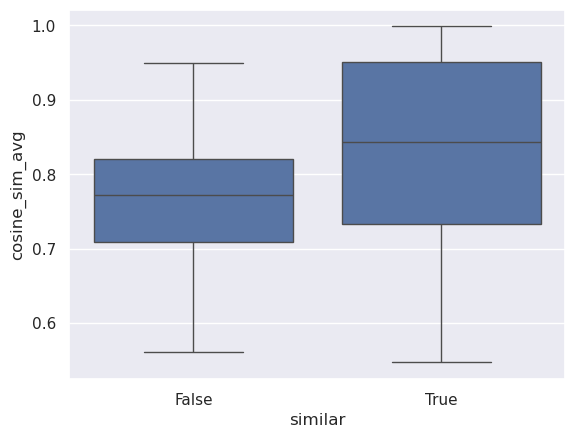

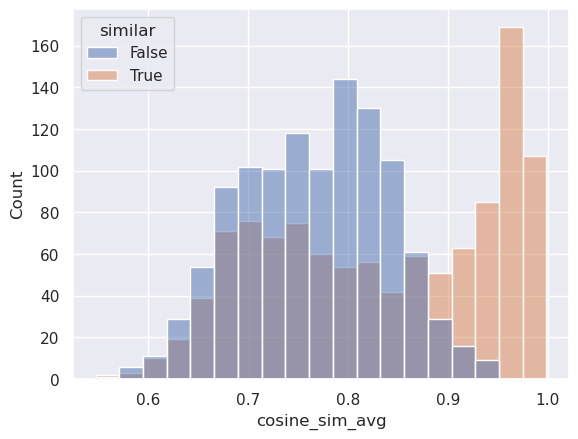

In [38]:
sns.boxplot(data=df, y="cosine_sim_avg", x="similar")
plt.show()
sns.histplot(data=df, x="cosine_sim_avg", hue="similar")
plt.show()

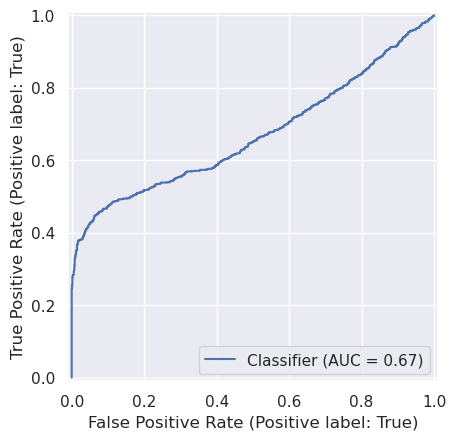

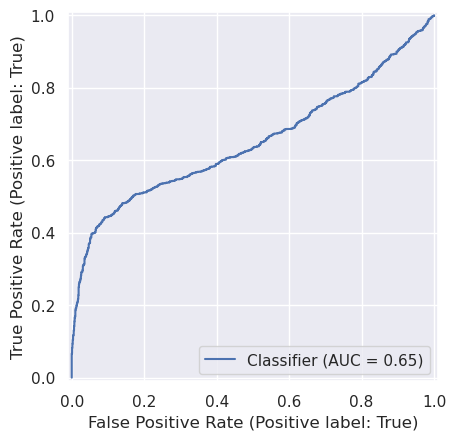

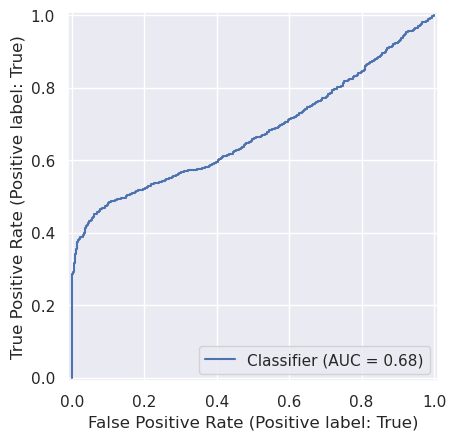

In [40]:
# fpr, tpr, treshold = roc_curve(df["Similar"].tolist(), df["cosine_sim"].tolist())
# print(treshold)
RocCurveDisplay.from_predictions(df["similar"].tolist(), df["cosine_sim"].tolist(), pos_label=True)
RocCurveDisplay.from_predictions(df["similar"].tolist(), df["cosine_sim_row"].tolist(), pos_label=True)
RocCurveDisplay.from_predictions(df["similar"].tolist(), df["cosine_sim_avg"].tolist(), pos_label=True)


# Old code


In [81]:
print(df.shape)
print(df.value_counts(subset=["len_profile_x", "len_profile_y"]).reset_index())
df.sort_index(inplace=True)
df.head()

(710, 8)
    len_profile_x  len_profile_y  count
0               3              3     81
1               4              5     56
2               3              4     53
3               4              4     43
4               3              5     39
5               4              3     39
6               3              6     32
7               5              4     31
8               5              5     31
9               4              7     27
10              6              6     26
11              7              5     26
12              6              5     24
13              4              6     23
14              6              7     22
15              5              6     22
16              7              6     21
17              5              3     20
18              3              7     18
19              6              4     18
20              5              7     14
21              7              4     14
22              6              3     12
23              7              

,genome_x,chr_x,len_profile_x,genome_y,chr_y,len_profile_y,seq_x,seq_y
3498,aar,sc-37,6,bol,C7,7,TATGGTACACTGTGTTCATCTACTTTGGAGAGAAGACCAAAGTATG...,CACTCTTCAGCTGCTTCCTTGGAGAGAAGACCGAAGAAAGGATTAG...
3500,aar,LG-1,7,bol,C5,7,TAATTCTGTTGCCTACCTCGTCCACGGCCAAACCTTCCTCTACCTC...,CATCCAGACTGTTGCCGCCCACGACCTCGTCCACGTCCACGTCCAA...
4048,aar,sc-652,5,bol,C3,5,TCGGAGGTTTCGCTACCAAATCGTATTCTCCGGGATCAAGACTCGC...,CACTTCCAGAGTTCTTCCATGGGGAATCTTCCACGTTCAAGAGCAG...
4049,aar,sc-167,5,bol,C9,5,CACCAATAATCTCCACAAGAACATGACCCATTTCTAAAATGATGAA...,TGGCTTTAGCTTCTTTGTTCGCTCGCTCTCGTAGAACAGCTTCCTC...
4050,aar,sc-167,5,ath,Chr5,5,CACCAATAATCTCCACAAGAACATGACCCATTTCTAAAATGATGAA...,CACCAATAATCTCTGCAGGAACATACTCCATTTCTAAAATGATGAA...


In [ ]:
df_c = df.copy() 
df_c['original_index'] = df_c.index

grouped = df_c.groupby(['len_profile_x', 'len_profile_y'])
shuffled_parts = []

for what, group in grouped:
    # makes sure group is not to small to shuffel
    if len(group) == 1:
        shuffled_parts.append(group)
        print("Error group to small !")
        continue
    
    shuffled_group = group.copy()
    same = True
    # shuffel everything till there are no same combinations as before
    while same:
        shuffled_values = shuffled_group[["genome_y", "chr_y", "len_profile_y", "seq_y"]].sample(frac=1, random_state=None).reset_index(drop=True)
        shuffled_group[["genome_y", "chr_y", "len_profile_y", "seq_y"]] = shuffled_values[["genome_y", "chr_y", "len_profile_y", "seq_y"]].values
        
        if shuffled_group[shuffled_group["seq_y"] == group["seq_y"]]["seq_y"].notna().sum() == 0:
            same = False 

    shuffled_parts.append(shuffled_group)

shuffled_df = pd.concat(shuffled_parts).sort_values("original_index").drop(columns="original_index")
# Check if there are not similar sequences at all
df[df[["seq_y"]] == shuffled_df[["seq_y"]]]["seq_y"].notna().sum()

# write to csv 
# profit

False    603
Name: count, dtype: int64